In [1]:
#let's import things you need

# for fast array manipulation
import numpy as np
# for plotting
import matplotlib.pyplot as plt
# for numerical ODE integration
from scipy.integrate import odeint
# for nonlinear equations
from scipy.optimize import fsolve
from matplotlib.pyplot import cm
# needed to calculate (complex) squareroots of negative numbers
from scipy import sqrt,integrate
#nullcline
import PyDSTool as dst
from PyDSTool.Toolbox import phaseplane as pp
from PyDSTool import args
# to display plots in-line
%matplotlib inline


#import sympy for fixed points?
import sympy as sm

#widget
from ipywidgets import interact, interactive
from IPython.display import clear_output, display, HTML
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation

In [2]:
# parameters
tau_e=20
tau_i=10
###########
#stimulus orientation
phi_1=45 
phi_2=135 #if you need two stimuli
###########
j_ee = 0.044
j_ie = 0.042
j_ei = 0.023
j_ii = 0.018
sigm_ori=32
sigm_ff=30
k=0.04
n=2.0
N=180



In [3]:
#####################################
#from pedro's firing rate network
# time parameters
t0 = 0
tmax =100
tstep = 0.1
t = np.arange(t0,tmax,tstep)
c=np.arange(1,101,1)

#all the initials
#stimulus 45
r_e_1=np.zeros((N,t.shape[0]))
r_i_1=np.zeros((N,t.shape[0]))
in_e_1=np.zeros((N,t.shape[0]))
in_i_1=np.zeros((N,t.shape[0]))
w_ee=np.zeros((N,N))
w_ei=np.zeros((N,N))
w_ie=np.zeros((N,N))
w_ii=np.zeros((N,N))
r_e_ss_1=np.zeros((N,t.shape[0]))
r_i_ss_1=np.zeros((N,t.shape[0]))
ext_in_1=np.zeros((N,100))
R_e_1=np.zeros((N,c.shape[0]))
R_i_1=np.zeros((N,c.shape[0]))
R_e_n_e_1=np.zeros((N,c.shape[0]))
R_e_n_i_1=np.zeros((N,c.shape[0]))
R_i_n_e_1=np.zeros((N,c.shape[0]))
R_i_n_i_1=np.zeros((N,c.shape[0]))
R_e_t_1=np.zeros((N,c.shape[0]))
R_i_t_1=np.zeros((N,c.shape[0]))
#stimulus 135
r_e_2=np.zeros((N,t.shape[0]))
r_i_2=np.zeros((N,t.shape[0]))
in_e_2=np.zeros((N,t.shape[0]))
in_i_2=np.zeros((N,t.shape[0]))
r_e_ss_2=np.zeros((N,t.shape[0]))
r_i_ss_2=np.zeros((N,t.shape[0]))
ext_in_2=np.zeros((N,100))
R_e_2=np.zeros((N,c.shape[0]))
R_i_2=np.zeros((N,c.shape[0]))
R_e_n_e_2=np.zeros((N,c.shape[0]))
R_e_n_i_2=np.zeros((N,c.shape[0]))
R_i_n_e_2=np.zeros((N,c.shape[0]))
R_i_n_i_2=np.zeros((N,c.shape[0]))
R_e_t_2=np.zeros((N,c.shape[0]))
R_i_t_2=np.zeros((N,c.shape[0]))
#stimulus 35+145
r_e_3=np.zeros((N,t.shape[0]))
r_i_3=np.zeros((N,t.shape[0]))
in_e_3=np.zeros((N,t.shape[0]))
in_i_3=np.zeros((N,t.shape[0]))
r_e_ss_3=np.zeros((N,t.shape[0]))
r_i_ss_3=np.zeros((N,t.shape[0]))
ext_in_3=np.zeros((N,100))
R_e_3=np.zeros((N,c.shape[0]))
R_i_3=np.zeros((N,c.shape[0]))
R_e_n_e_3=np.zeros((N,c.shape[0]))
R_e_n_i_3=np.zeros((N,c.shape[0]))
R_i_n_e_3=np.zeros((N,c.shape[0]))
R_i_n_i_3=np.zeros((N,c.shape[0]))
R_e_t_3=np.zeros((N,c.shape[0]))
R_i_t_3=np.zeros((N,c.shape[0]))
#firing rate sum
sum_ext=np.zeros(c.shape[0])
sum_net_e_e=np.zeros(c.shape[0])
sum_net_e_i=np.zeros(c.shape[0])
sum_net_i_e=np.zeros(c.shape[0])
sum_net_i_i=np.zeros(c.shape[0])

#function for the shortest distance
def sh_d(x):
    x=np.where(x<=90,x,(180-x))
    return x
#going to calculate the external input first
h_b=np.arange(1,181,1)
h_d1a=np.absolute(np.subtract(h_b,phi_1))
h_d1=sh_d(h_d1a)
h_d2a=np.absolute(np.subtract(h_b,phi_2))
h_d2=sh_d(h_d2a)
h_1=np.exp(-((h_d1**2)/(2*(sigm_ff**2))))
h_2=np.exp(-((h_d2**2)/(2*(sigm_ff**2))))

#equations
#weights
w_1=np.arange(1,181,1)
w_c,w_r=np.meshgrid(w_1,w_1)
w_da=np.absolute(w_r-w_c)
w_d=sh_d(w_da)
w_ee=j_ee*np.exp(-((w_d**2)/(2*(sigm_ori**2))))
w_ie=j_ie*np.exp(-((w_d**2)/(2*(sigm_ori**2))))
w_ei=j_ei*np.exp(-((w_d**2)/(2*(sigm_ori**2))))
w_ii=j_ii*np.exp(-((w_d**2)/(2*(sigm_ori**2))))


#let's start euler
#this iteration may detect only the steady state value_so if you want r vs time, make another iteration for it
dt=t.shape[0]-1

#make function for the stimulus orientation?

for j in range(0,c.shape[0]):
    c_l=c[j]
    for i in range(1,t.shape[0]):
        r_e_1[:,i]=((-r_e_1[:,i-1]+r_e_ss_1[:,i-1])/tau_e)*tstep+r_e_1[:,i-1]
        r_i_1[:,i]=((-r_i_1[:,i-1]+r_i_ss_1[:,i-1])/tau_i)*tstep+r_i_1[:,i-1]
        in_e_1[:,i]=c_l*h_1+np.dot(w_ee,r_e_1[:,i])-np.dot(w_ei,r_i_1[:,i])
        in_i_1[:,i]=c_l*h_1+np.dot(w_ie,r_e_1[:,i])-np.dot(w_ii,r_i_1[:,i])
        in_e_1[in_e_1[:,i]<0,i]=0
        in_i_1[in_i_1[:,i]<0,i]=0
        r_e_ss_1[:,i]=k*np.power(in_e_1[:,i],n)
        r_i_ss_1[:,i]=k*np.power(in_i_1[:,i],n)
    ext_in_1[:,j]=c_l*h_1 #external input
    R_e_1[:,j]=r_e_1[:,dt] #firing rate of E unit
    R_e_n_e_1[:,j]=np.dot(w_ee,r_e_1[:,dt]) #network E of E unit
    R_e_n_i_1[:,j]=np.dot(w_ei,r_i_1[:,dt]) #network I of E unit
    R_e_t_1[:,j]=in_e_1[:,dt] #I hope this is the net input of E unit
    R_i_1[:,j]=r_i_1[:,dt] #firing rate of I unit
    R_i_n_e_1[:,j]=np.dot(w_ie,r_e_1[:,dt]) #network E of I unit
    R_i_n_i_1[:,j]=np.dot(w_ii,r_i_1[:,dt]) #network I of I unit
    R_i_t_1[:,j]=in_i_1[:,dt] #I hope this is the net input of I unit
    sum_ext[j]=np.sum(c_l*h_1)
    sum_net_e_e[j]=np.sum(np.dot(w_ee,r_e_1[:,dt]))
    sum_net_e_i[j]=np.sum(np.dot(w_ei,r_i_1[:,dt]))
    sum_net_i_e[j]=np.sum(np.dot(w_ie,r_e_1[:,dt]))
    sum_net_i_i[j]=np.sum(np.dot(w_ii,r_i_1[:,dt]))


for j in range(0,c.shape[0]):
    c_l=c[j]
    for i in range(1,t.shape[0]):
        r_e_2[:,i]=((-r_e_2[:,i-1]+r_e_ss_2[:,i-1])/tau_e)*tstep+r_e_2[:,i-1]
        r_i_2[:,i]=((-r_i_2[:,i-1]+r_i_ss_2[:,i-1])/tau_i)*tstep+r_i_2[:,i-1]
        in_e_2[:,i]=c_l*h_2+np.dot(w_ee,r_e_2[:,i])-np.dot(w_ei,r_i_2[:,i])
        in_i_2[:,i]=c_l*h_2+np.dot(w_ie,r_e_2[:,i])-np.dot(w_ii,r_i_2[:,i])
        in_e_2[in_e_2[:,i]<0,i]=0
        in_i_2[in_i_2[:,i]<0,i]=0
        r_e_ss_2[:,i]=k*np.power(in_e_2[:,i],n)
        r_i_ss_2[:,i]=k*np.power(in_i_2[:,i],n)
    ext_in_2[:,j]=c_l*h_2 #external input
    R_e_2[:,j]=r_e_2[:,dt] #firing rate of E unit
    R_i_2[:,j]=r_i_2[:,dt] #firing rate of I unit

    
for j in range(0,c.shape[0]):
    c_l=c[j]
    for i in range(1,t.shape[0]):
        r_e_3[:,i]=((-r_e_3[:,i-1]+r_e_ss_3[:,i-1])/tau_e)*tstep+r_e_3[:,i-1]
        r_i_3[:,i]=((-r_i_3[:,i-1]+r_i_ss_3[:,i-1])/tau_i)*tstep+r_i_3[:,i-1]
        in_e_3[:,i]=c_l*h_1+c_l*h_2+np.dot(w_ee,r_e_3[:,i])-np.dot(w_ei,r_i_3[:,i])
        in_i_3[:,i]=c_l*h_1+c_l*h_2+np.dot(w_ie,r_e_3[:,i])-np.dot(w_ii,r_i_3[:,i])
        in_e_3[in_e_3[:,i]<0,i]=0
        in_i_3[in_i_3[:,i]<0,i]=0
        r_e_ss_3[:,i]=k*np.power(in_e_3[:,i],n)
        r_i_ss_3[:,i]=k*np.power(in_i_3[:,i],n)
    ext_in_3[:,j]=c_l*h_1+c_l*h_2 #external input
    R_e_3[:,j]=r_e_3[:,dt] #firing rate of E unit
    R_i_3[:,j]=r_i_3[:,dt] #firing rate of I unit


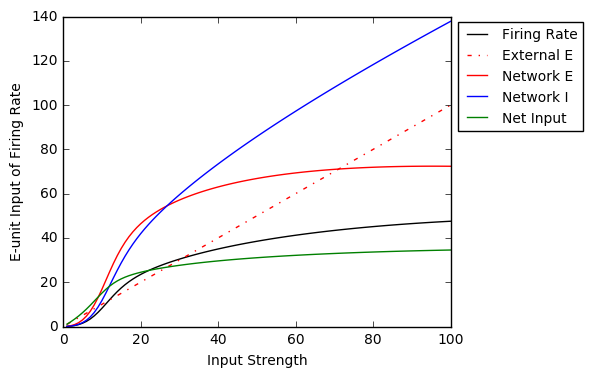

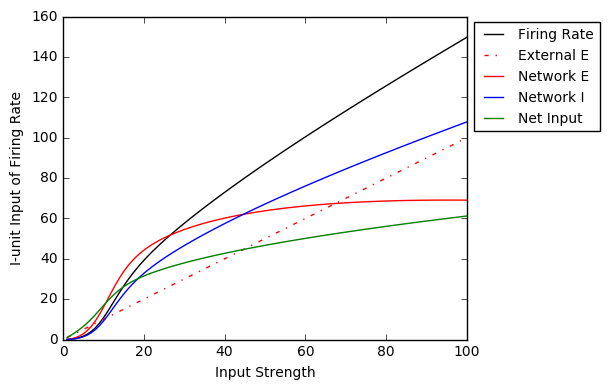

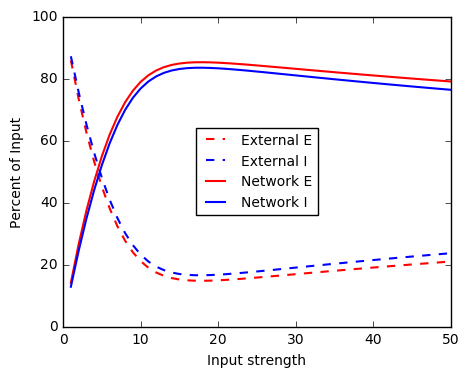

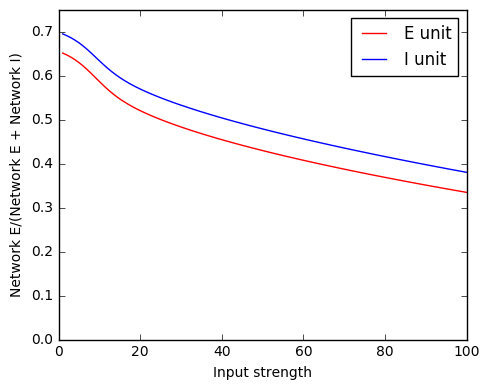

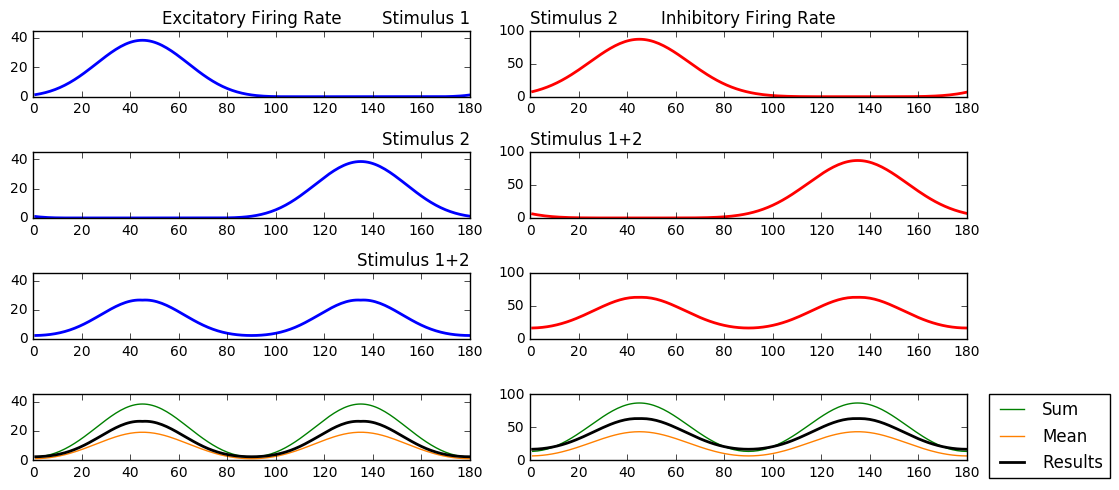

In [61]:
#before doing plot, let's do some calculations
#for firing rate vs input strength(h(x))
#use steady state firing rate
#external input
ch=ext_in_1[44,:]

#excitatory
efr_e=R_e_1[44,:]
enetw_e=R_e_n_e_1[44,:]
enetw_i=R_e_n_i_1[44,:]
einp=R_e_t_1[44,:]

#inhibitory
ifr_e=R_i_1[44,:]
inetw_e=R_i_n_e_1[44,:]
inetw_i=R_i_n_i_1[44,:]
iinp=R_i_t_1[44,:]

#plots with c=45

#Unit firing rate
pllt=plt.figure(figsize=(5,4))
plt.plot(c,efr_e,'-k',label='Firing Rate')
plt.plot(c,ch,'-.r',label='External E')
plt.plot(c,enetw_e,'-r',label='Network E')
plt.plot(c,enetw_i,'-b',label='Network I')
plt.plot(c,einp,'-g',label='Net Input')
plt.xlabel('Input Strength')
plt.ylabel('E-unit Input of Firing Rate')
plt.legend(loc=2, prop={'size':10}, bbox_to_anchor=(1, 0.005, .5, 1))

pllt=plt.figure(figsize=(5,4))
plt.plot(c,ifr_e,'-k',label='Firing Rate')
plt.plot(c,ch,'-.r',label='External E')
plt.plot(c,inetw_e,'-r',label='Network E')
plt.plot(c,inetw_i,'-b',label='Network I')
plt.plot(c,iinp,'-g',label='Net Input')
plt.xlabel('Input Strength')
plt.ylabel('I-unit Input of Firing Rate')
plt.legend(loc=2, prop={'size':10}, bbox_to_anchor=(1, 0.005, .5, 1))
plt.tight_layout()

#percent of input
inp_e_t=sum_ext+sum_net_e_e+sum_net_e_i
inp_i_t=sum_ext+sum_net_i_e+sum_net_i_i
ext_e_p=100*np.divide(sum_ext,inp_e_t)
ext_i_p=100*np.divide(sum_ext,inp_i_t)
net_e_p=100*np.divide((sum_net_e_e+sum_net_e_i),inp_e_t)
net_i_p=100*np.divide((sum_net_i_e+sum_net_i_i),inp_i_t)
net_only_e=np.divide(sum_net_e_e,(sum_net_e_e+sum_net_e_i))
net_only_i=np.divide(sum_net_i_e,(sum_net_i_e+sum_net_i_i))

    
plt.figure(figsize=(5,4))
plt.xlim([0,50])
plt.ylim([0,100])
plt.plot(c,ext_e_p,'--r',linewidth=1.5,label='External E')
plt.plot(c,ext_i_p,'--b',linewidth=1.5,label='External I')
plt.plot(c,net_e_p,'-r',linewidth=1.5, label='Network E')
plt.plot(c,net_i_p,'-b',linewidth=1.5, label='Network I')
plt.xlabel('Input strength')
plt.ylabel('Percent of Input')
plt.legend(loc=10, prop={'size':10})
plt.figure(figsize=(5,4))
plt.ylim([0,0.75])
plt.plot(c,net_only_e,'r',label='E unit')
plt.plot(c,net_only_i,'b',label='I unit')
plt.xlabel('Input strength')
plt.ylabel('Network E/(Network E + Network I)')
plt.legend(loc=1)
plt.tight_layout()

#Firing rate vs preferred orientation
#c=50
#excitatory
fr_e_1=R_e_1[:,49]
fr_e_2=R_e_2[:,49]
fr_e_3=R_e_3[:,49]
ticksye= np.arange(0, 41, 20)
fr=plt.figure(figsize=(10,5))
r_e_ori_1=plt.subplot(4,2,1)
plt.title('Excitatory Firing Rate')
plt.title('Stimulus 1', loc='right')
r_e_ori_1.set_ylim([0,45])
r_e_ori_1.set_yticks(ticksye)
plt.plot(h_b,fr_e_1,linewidth=2)
r_e_ori_2=plt.subplot(4,2,3)
plt.title('Stimulus 2', loc='right')
plt.plot(h_b,fr_e_2,linewidth=2)
r_e_ori_2.set_ylim([0,45])
r_e_ori_2.set_yticks(ticksye)
r_e_ori_3=plt.subplot(4,2,5)
plt.plot(h_b,fr_e_3,linewidth=2)
plt.title('Stimulus 1+2', loc='right')
r_e_ori_3.set_ylim([0,45])
r_e_ori_3.set_yticks(ticksye)
r_e_ori_sum=plt.subplot(4,2,7)
plt.plot(h_b,(fr_e_1+fr_e_2),'g',label='Sum')
plt.plot(h_b,(fr_e_1+fr_e_2)/2,'#FF8000',label='Mean')
plt.plot(h_b,fr_e_3,'k',linewidth=2,label='Results')
r_e_ori_sum.set_ylim([0,45])
r_e_ori_sum.set_yticks(ticksye)
#inhibitory
ticksyi= np.arange(0, 101, 50)
fr_i_1=R_i_1[:,49]
fr_i_2=R_i_2[:,49]
fr_i_3=R_i_3[:,49]
r_i_ori_1=plt.subplot(4,2,2)
plt.title('Inhibitory Firing Rate')
plt.title('Stimulus 1', loc='left')
r_i_ori_1.set_ylim([0,100])
r_i_ori_1.set_yticks(ticksyi)
plt.plot(h_b,fr_i_1,'r',linewidth=2)
plt.title('Stimulus 2', loc='left')
r_i_ori_2=plt.subplot(4,2,4)
plt.plot(h_b,fr_i_2,'r',linewidth=2)
plt.title('Stimulus 1+2', loc='left')
r_i_ori_2.set_ylim([0,100])
r_i_ori_2.set_yticks(ticksyi)
r_i_ori_3=plt.subplot(4,2,6)
plt.plot(h_b,fr_i_3,'r',linewidth=2)
r_i_ori_3.set_ylim([0,100])
r_i_ori_3.set_yticks(ticksyi)
r_i_ori_sum=plt.subplot(4,2,8)
plt.plot(h_b,(fr_i_1+fr_i_2),'g',label='Sum')
plt.plot(h_b,(fr_i_1+fr_i_2)/2,'#FF8000',label='Mean')
plt.plot(h_b,fr_i_3,'k',linewidth=2,label='Results')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
r_i_ori_sum.set_ylim([0,45])
r_i_ori_sum.set_yticks(ticksyi)
plt.tight_layout()